In [2]:
# this is a little trick to make sure the the notebook takes up most of the screen:
from IPython.display import HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Recommendation to leave the logging config like this, otherwise you'll be flooded with unnecessary info
import logging
logging.basicConfig(level=logging.WARNING, format='%(levelname)s:%(message)s')  


# Recommendation: logging config like this, otherwise you'll be flooded with unnecessary information
import logging
logging.basicConfig(level=logging.ERROR)

import sys
sys.path.append('../')

In [3]:
# import all modeling concepts
from crestdsl.model import *

# import the simulator
from crestdsl.simulation import Simulator

# import the plotting libraries that can visualise the CREST systems
from crestdsl.ui import elk

# we will create tests for each Entity
import unittest

class TestClass(unittest.TestCase):
    @classmethod
    def runall(cls):
        tests = unittest.TestLoader().loadTestsFromTestCase(cls)
        return unittest.TextTestRunner().run(tests)
    

In [4]:
class Resources(object):
    electricity = Resource("Watt", REAL)
    switch = Resource("switch", ["on", "off"])
    pourcent = Resource("%", REAL) 
    light = Resource("Lumen", REAL)
    time = Resource("minutes", REAL)
    water = Resource("litre", REAL)
    celsius = Resource("Celsius", REAL)
    boolean = Resource("bool", BOOL)
    presence = Resource("presence", ["detected", "no presence"])
    onOffAuto = Resource("onOffAutoSwitch", ["on", "off", "auto"])
    integer = Resource("integer", INTEGER)
    weight = Resource("kg", REAL)
    lenght = Resource("m", REAL)
    area = Resource("m²", REAL)

In [5]:
class ElectricalDevice(object):
    electricity_in = Input(Resources.electricity, value=0)
    req_electricity_out = Output(Resources.electricity, value=0)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.621s

OK


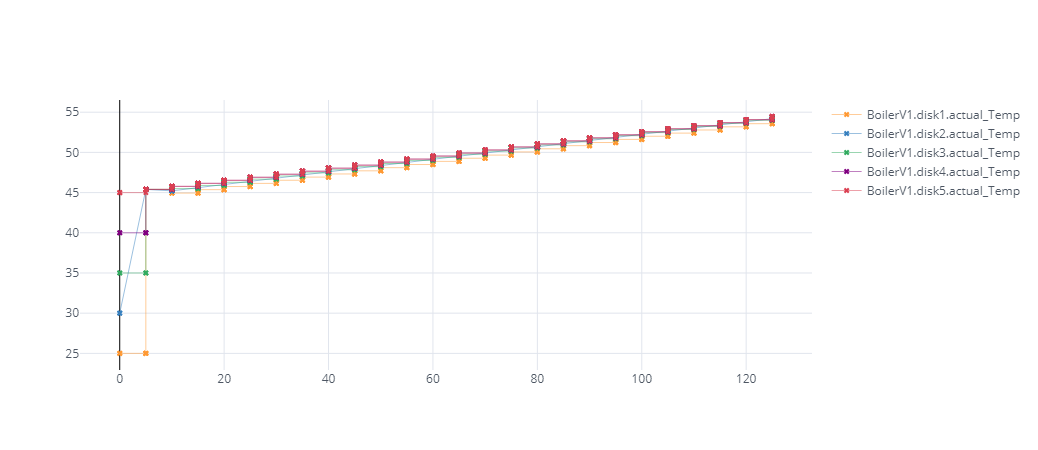

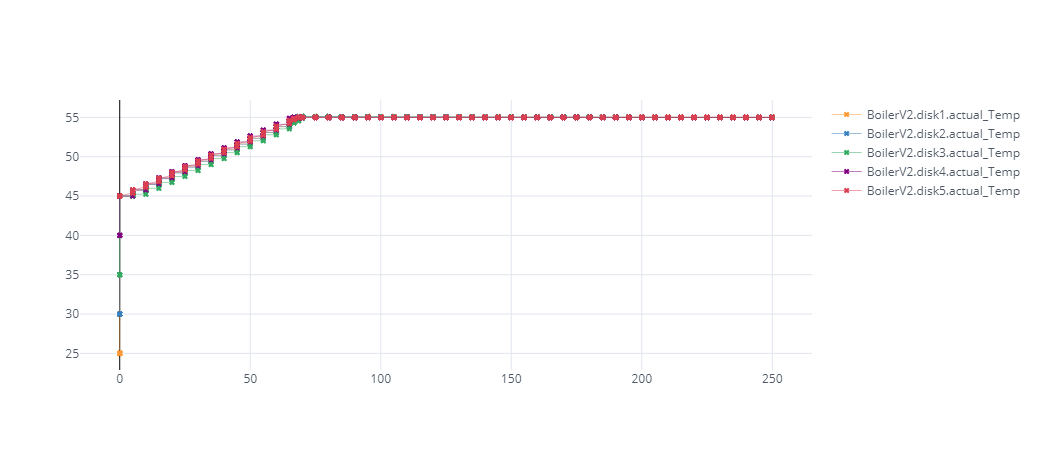

In [6]:
#The SmartHome use multiple entities created is those files, you need them to make this file work

%run ElectricalPart.ipynb
%run HomeElements.ipynb
%run Boilers.ipynb

In [7]:
# Permit to switch on the lights manually, or automatically if enable, when someone is home and there is no enought light in it

class LightController(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    presence_in = Input(Resources.presence, "no presence")
    switch_in = Input(Resources.onOffAuto, "auto")
    luminosity_in = Input(Resources.light, 200)
    light_threshold = Local(Resources.light, 1000)
    
    out = Output(Resources.onOffAuto, value="off") # on/off
    
    def __init__(self, threshold=1000):
        self.light_threshold.value = threshold
        
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """
    
    state = current = State()
    
    """ - - - - - - - UPDATES - - - - - - - - - - """    
    
    @update(state=state, target=out)
    def update_output(self, dt):
        if self.switch_in.value == "auto":
            if self.presence_in.value == "detected" and self.luminosity_in.value < self.light_threshold.value:
                return "on"
            else:
                return "off"
        elif self.switch_in.value == "on":
            return "on"
        elif self.switch_in.value == "off":
            return "off"
    
#elk.plot(LightControler())

In [8]:
# Really bad model of the light send by the sun, we didn't needed good model to test our solar panels

class Sun(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    time_In = Input(Resources.time, 0)
    time_Local = Local(Resources.time, 0)
    light_Out = Output(Resources.light, 0)
  
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    #None
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    #None
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        

    state = current = State()
    
    time_propagation = Influence(source = time_In, target = time_Local)
    
    """ - - - - - - - UPDATES - - - - - - - - - - """

    # We take dt = 1 minute 
    
    @update(state = state, target = light_Out)
    def update_light_out(self, dt):
        light = 0
        if(self.time_Local.value%1440 > 21*60):
            light = 0
        elif(self.time_Local.value%1440 > 16*60):
            light = 20000*(21*60-self.time_Local.value)//60 #On veut 20000*un nombre flottant entre 0 et 5
        elif(self.time_Local.value%1440 > 12*60):
            light = 100000
        elif(self.time_Local.value%1440 > 7*60):
            light = 20000*(abs(self.time_Local.value - 7*60))//60  #On veut 20000*un nombre flottant entre 0 et 5
        else:
            light = 0
        
        return light
    
#elk.plot(Sun())

sun=Sun()
sun.time_In.value = 691
ssim=Simulator(sun)
ssim.stabilize()
ssim.plot()

In [9]:
# Creation of a Room entity, with only windows and lights, can also represent the Entrance of our Home

class Room(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    #light_In = Input(Resources.light, 200)
    windows = Local(Resources.integer, 3)
    room_cons = Output(Resources.electricity, 0)
    
        
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    
    light_controls = LightController()
    electricity_splitter = Splitter()       
    
    def __init__(self, number_windows=0, number_lamps=0):
        
        self.windows.value = number_windows
        
        installed_lamps = []
        for i in range(number_lamps):
            lamp = api.add(self, f"lamp_{i+1}", Lights())
            installed_lamps.append(lamp)
            api.add(self, f"connect_lamp_{i+1}_switch", Influence(source=self.light_controls.out, target=lamp.switch_in))
        self.electricity_splitter.connect_devices(installed_lamps)
                
        api.pullup(presence=self.light_controls.presence_in, 
               lightswitch=self.light_controls.switch_in,
               light_outside=self.light_controls.luminosity_in)
        
        api.pullup(self.electricity_splitter.electricity_in,
                  self.electricity_splitter.req_electricity_out)
                
        api.dependencies((self.req_electricity_out, self.lightswitch),
                           (self.req_electricity_out, self.presence)) 
        
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        
        
    state = current = State()
           
    """ - - - - - - - UPDATES - - - - - - - - - - """    
    
#elk.plot(Room(number_lamps=2))    
room1 = Room(number_lamps=2)

room1.electricity_in.value = 100
room1.presence.value = "detected"

sim = Simulator(room1)

sim.stabilise()
#sim.advance(3)
sim.plot()



In [10]:
# Bathroom, contains the Boiler and the Shower, other devices can be added, boiler can be modified easily 

class BathRoom(Entity):

    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    light_In = Input(Resources.light, 200)
    windows = Local(Resources.integer, 3)
    
        
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    
    light_controls = LightController()
    electricity_splitter = Splitter()      
    water_splitter = WaterSplitter()
    
    def __init__(self, number_windows=0, number_lamps=0):
        
        self.windows.value = number_windows
        
        installed_devices = []
        for i in range(number_lamps):
            lamp = api.add(self, f"lamp_{i+1}", Lights())
            installed_devices.append(lamp)
            api.add(self, f"connect_lamp_{i+1}_switch", Influence(source=self.light_controls.out, target=lamp.switch_in))
        
        boiler = api.add(self, "boiler", DynamicBoilerV1(nb_disk=5, consumption=4000, efficiency = 1, boiler_Capacity = 60))

        installed_devices.append(boiler)
        
        self.electricity_splitter.connect_devices(installed_devices)
        
        api.pullup(presence=self.light_controls.presence_in, 
               lightswitch=self.light_controls.switch_in,
               light_outside=self.light_controls.luminosity_in)
        
        api.pullup(self.electricity_splitter.electricity_in,
                  self.electricity_splitter.req_electricity_out)
                
        api.dependencies((self.req_electricity_out, self.lightswitch),
                           (self.req_electricity_out, self.presence))
        
        water_devices = []
        
        shower = api.add(self, "shower", Shower())
        water_devices.append(shower)
        
        water_devices.append(boiler)
        
        self.water_splitter.connect_water_devices(water_devices)
        
        api.pullup(switch_boiler=self.boiler.switch_boiler, 
               switch_shower=self.shower.switch_shower)
        
        api.pullup(self.water_splitter.water_in,
                  self.water_splitter.req_water_out)
        
        api.dependencies((self.req_water_out, self.switch_boiler),
                           (self.req_water_out, self.switch_shower))
     
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        
        
    state = current = State()
           


#elk.plot(BathRoom(2,2))  

br = BathRoom(4,6)

br.electricity_in.value = 5000
br.presence.value = "detected"
br.switch_shower.value = "on"
br.water_in.value = 30

sim = Simulator(br)

sim.stabilise()
sim.advance(3)
sim.plot()

In [11]:
# AS it doesn't contains any connected devices $, the Bedroom is just a room

class BedRoom(Room,Entity):

    """ - - - - - - - PORTS - - - - - - - - - - """
    
    light_In = Input(Resources.light, 200)
    windows = Local(Resources.integer, 3)
    
        
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    
    light_controls = LightController()
    electricity_splitter = Splitter()       
    
    
elk.plot(BedRoom(4,4))   

In [12]:
# The living room contains all other devices, receive the electricity from the electric part and the water from the boiler in the BathRoom

class LivingRoom(Entity):

    """ - - - - - - - PORTS - - - - - - - - - - """
    
    light_In = Input(Resources.light, 200)
    windows = Local(Resources.integer, 3)
    
        
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    
    light_controls = LightController()
    electricity_splitter = Splitter()    
    water_splitter = WaterSplitter()
    television = TV()
    vacuum_robot = Vacuum_Robot()
    dishwasher = Dishwasher()
        
    def __init__(self, number_windows=0, number_lamps=0):
        
        self.windows.value = number_windows
        
        installed_devices = []
        for i in range(number_lamps):
            lamp = api.add(self, f"lamp_{i+1}", Lights())
            installed_devices.append(lamp)
            api.add(self, f"connect_lamp_{i+1}_switch", Influence(source=self.light_controls.out, target=lamp.switch_in))
        
        installed_devices.append(self.television)
        installed_devices.append(self.vacuum_robot)
        installed_devices.append(self.dishwasher)

        self.electricity_splitter.connect_devices(installed_devices)
                
        api.pullup(presence=self.light_controls.presence_in, 
               lightswitch=self.light_controls.switch_in,
               light_outside=self.light_controls.luminosity_in)
        
        api.pullup(self.electricity_splitter.electricity_in,
                  self.electricity_splitter.req_electricity_out)
                
        api.dependencies((self.req_electricity_out, self.lightswitch),
                           (self.req_electricity_out, self.presence))
        
        api.add(self, "influence_vacuum", Influence(source = self.presence, target = self.vacuum_robot.presence_In))
        
        water_devices = []
        
#         dishwasher = api.add(self, "dishwasher", Dishwasher())
        water_devices.append(self.dishwasher)
                
        self.water_splitter.connect_water_devices(water_devices)
        
        api.pullup(switch_DW = self.dishwasher.switch_usageDW)
        
        api.pullup(self.water_splitter.water_in, self.water_splitter.req_water_out)
        
        api.dependencies((self.req_water_out, self.switch_DW))
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        
        
    state = current = State()
           

    
elk.plot(LivingRoom(4,6))   
"""
LR = LivingRoom(4,6)

LR.electricity_in.value=5000
LR.presence.value = "detected"
#LR.television.switch_TV.value="on"
#LR.television.electricity_in.value=1000
LR.dishwasher.switch_usageDW.value="on"
#LR.dishwasher.electricity_in.value=1000
LR.vacuum_robot.electricity_in.value=1000

simLR = Simulator(LR)
simLR.stabilize()
simLR.advance(1)
simLR.plot()"""

'\nLR = LivingRoom(4,6)\n\nLR.electricity_in.value=5000\nLR.presence.value = "detected"\n#LR.television.switch_TV.value="on"\n#LR.television.electricity_in.value=1000\nLR.dishwasher.switch_usageDW.value="on"\n#LR.dishwasher.electricity_in.value=1000\nLR.vacuum_robot.electricity_in.value=1000\n\nsimLR = Simulator(LR)\nsimLR.stabilize()\nsimLR.advance(1)\nsimLR.plot()'

In [13]:
# Contains all the devices from the "ElectricalPart" file

class ElectricPart(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    lux_Sun = Input(Resources.light, 0)
    
    time = Local(Resources.time, 0)
    
    elec_out = Output(resource=Resources.electricity, value=0) 
    
    def __init__(self, starting_time=0):
        self.time.value = starting_time
    
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    battery = Battery()
    testGrid = Power_Grid()
    sun = Sun()
    panel = SolarPanel()
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    time_propagation = Influence(source=time, target = sun.time_In)
    sun_light_propagation = Influence(source=sun.light_Out, target = panel.lux_In)
    panel_elec_propagation = Influence(source=panel.electricity_Out, target = battery.panel_electricity)
    switch_power_propagation = Influence(battery.switch_power, testGrid.switch_PG)
    
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """
    state = current = State()
    
    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    @update(state = state, target = time)
    def update_time(self, dt):
        return self.time.value + dt
    
    @update(state=state, target=elec_out)
    def update_elec_out(self, dt):
        # no electricity
        return self.battery.battery_out.value + self.testGrid.electricity_Supply.value

# create an instance!
#elk.plot(ElectricPart())

EP = ElectricPart()
EP.time.value = 720
simEP = Simulator(EP)
simEP.stabilize()
#simEP.advance(20)
simEP.plot()

In [14]:
# Entity of the SmartHome, contains all the Entities met before, and the influences between all rooms

class SmartHome(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    lux_in = Input(Resources.light, 500)
    
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    elec = ElectricPart()
    entrance = Room(3,2)
    bathR = BathRoom(2,2)
    bedR = BedRoom(4,4)
    livR = LivingRoom(4,6)
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    
    elec_propagation_ent = Influence(source=elec.elec_out, target = entrance.electricity_in)
    elec_propagation_bed = Influence(source=elec.elec_out, target = bedR.electricity_in)
    elec_propagation_bath = Influence(source=elec.elec_out, target = bathR.electricity_in)
    elec_propagation_liv = Influence(source=elec.elec_out, target = livR.electricity_in)
    
    light_propagation = Influence(lux_in, elec.lux_Sun)
   
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """
    state = current = State()
    
    """ - - - - - - - UPDATES - - - - - - - - - - """
    

# create an instance!
elk.plot(SmartHome())

sh = SmartHome()
simsh = Simulator(sh)
simsh.stabilize()
simsh.plot(level=2)